In [1]:
#! git clone https://github.com/jpospinalo/MachineLearning

In [2]:
import numpy as np
import h5py
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import random


In [3]:
def load_cats():
    train_dataset = h5py.File('./MachineLearning/NN/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('./MachineLearning/NN/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes

    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [4]:
def verImagenes(index):
    if index >= 209:
      return "No hay mas imagenes, escoger entre -209 y 208"
    plt.figure(figsize=(6,6))
    plt.imshow(train_set_x_orig[index])
    plt.show()

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from io import BytesIO
import requests

def preprocess_image_unique(img):
    """
    Preprocesa la imagen para adaptarla al modelo:
    - Asegura que la imagen esté en formato RGB.
    - Redimensiona la imagen a 64x64 píxeles.
    - Normaliza los valores entre 0 y 1.
    """
    # Convertir a RGB si no lo está
    if img.mode != 'RGB':
        img = img.convert('RGB')
    
    # Redimensionar y normalizar
    img_resized = img.resize((64, 64))
    img_array = np.array(img_resized) / 255.0
    return img_array.reshape(1, -1), img_array.reshape(1, 64, 64, 3)


def predict_image(index=None, local_image_path=None, url_image_data=None):
    """
    Predice si una imagen es un gato o no, utilizando los cinco modelos entrenados.
    
    Args:
        index (int): Índice de la imagen en el dataset.
        local_image_path (str): Ruta local de la imagen a cargar.
        url_image_data (str): URL de la imagen a cargar.
    """
    # Manejo de entrada
    if index is not None:  # Predicción desde el dataset
        if index < -209 or index > 208:
            return "Índice fuera de rango. Escoge entre -209 y 208."
        img_array = train_set_x_orig[index]
        X_input_flat, X_input_cnn = preprocess_image_unique(Image.fromarray(img_array))
        plt.imshow(img_array)
        plt.title(f"Imagen del Dataset (Índice: {index})")
        plt.axis("off")
        plt.show()
    elif local_image_path is not None:  # Predicción desde archivo local
        try:
            img = Image.open(local_image_path)
            X_input_flat, X_input_cnn = preprocess_image_unique(img)
            plt.imshow(img)
            plt.title("Imagen Cargada Localmente")
            plt.axis("off")
            plt.show()
        except Exception as e:
            return f"Error al cargar la imagen local: {e}"
    elif url_image_data is not None:  # Predicción desde URL
        try:
            response = requests.get(url_image_data, stream=True)
            response.raise_for_status()  # Asegurarse de que la URL es válida
            img = Image.open(BytesIO(response.content))
            X_input_flat, X_input_cnn = preprocess_image_unique(img)
            plt.imshow(img)
            plt.title("Imagen desde URL")
            plt.axis("off")
            plt.show()
        except Exception as e:
            return f"Error al procesar la URL de la imagen: {e}"
    else:
        return "Proporciona un índice, ruta local o URL de imagen."

    # Predicciones
    predictions = {}
    
    # Random Forest
    predictions["Random Forest"] = rf_model.predict(X_input_flat)[0]
    
    # SVM
    predictions["SVM"] = svm_model.predict(X_input_flat)[0]
    
    # Gradient Boosting
    predictions["Gradient Boosting"] = gb_model.predict(X_input_flat)[0]
    
    # CNN
    predictions["CNN"] = int(cnn_model.predict(X_input_cnn)[0, 0] > 0.5)
    
    # XGBoost
    predictions["XGBoost"] = xgb_model.predict(X_input_flat)[0]

    # Mostrar resultados
    for model, pred in predictions.items():
        print(f"{model}: {'Gato' if pred == 1 else 'No Gato'}")


In [16]:
def interact_predict_image_v2(local_image_path=None, url_image_data=None):
    """
    Predice si una imagen es un gato o no, evalúa todos los modelos de una vez y actualiza los modelos en función de la respuesta del usuario.
    
    Args:
        local_image_path (str): Ruta local de la imagen a cargar.
        url_image_data (str): URL de la imagen a cargar.
    """
    global rf_model, svm_model, gb_model, cnn_model, xgb_model  # Declarar variables globales

    def preprocess_image(img):
        """Preprocesa la imagen para adaptarla al modelo (64x64, normalización)."""
        if img.mode != 'RGB':
            img = img.convert('RGB')
        img_resized = img.resize((64, 64))
        img_array = np.array(img_resized) / 255.0
        return img_array.reshape(1, -1), img_array.reshape(1, 64, 64, 3)

    # Cargar y procesar la imagen
    if local_image_path is not None:
        img = Image.open(local_image_path)
    elif url_image_data is not None:
        response = requests.get(url_image_data, stream=True)
        response.raise_for_status()
        img = Image.open(BytesIO(response.content))
    else:
        return "Proporciona una ruta local o URL de imagen."

    X_input_flat, X_input_cnn = preprocess_image(img)
    plt.imshow(img)
    plt.title("Imagen cargada")
    plt.axis("off")
    plt.show()

    # Realizar predicciones iniciales
    predictions = {
        "Random Forest": rf_model.predict(X_input_flat)[0],
        "SVM": svm_model.predict(X_input_flat)[0],
        "Gradient Boosting": gb_model.predict(X_input_flat)[0],
        "CNN": int(cnn_model.predict(X_input_cnn)[0, 0] > 0.5),
        "XGBoost": xgb_model.predict(X_input_flat)[0]
    }

    # Mostrar resultados iniciales
    print("\nResultados iniciales de las predicciones:")
    for model, pred in predictions.items():
        print(f"{model}: {'Gato' if pred == 1 else 'No Gato'}")

    # Preguntar si la imagen es un gato
    is_cat = input("\n¿La imagen es un Gato? (si/no): ").strip().lower()
    true_label = 1 if is_cat == "si" else 0

    # Actualizar modelos según las respuestas
    X_new_flat = X_input_flat
    X_new_cnn = X_input_cnn

    for model_name, prediction in predictions.items():
        if prediction == true_label:
            print(f"{model_name}: Predicción correcta. Actualizando para reforzar el modelo...")
            # Entrenar el modelo con los datos nuevos para hacerlo más robusto
            if model_name == "Random Forest":
                rf_model.fit(np.vstack((X_train, X_new_flat)), np.hstack((y_train, [true_label])))
            elif model_name == "SVM":
                svm_model.fit(np.vstack((X_train, X_new_flat)), np.hstack((y_train, [true_label])))
            elif model_name == "Gradient Boosting":
                gb_model.fit(np.vstack((X_train, X_new_flat)), np.hstack((y_train, [true_label])))
            elif model_name == "CNN":
                cnn_model.fit(np.vstack((X_train_cnn, X_new_cnn)), np.hstack((y_train, [true_label])), epochs=5, batch_size=32, verbose=0)
            elif model_name == "XGBoost":
                xgb_model.fit(np.vstack((X_train, X_new_flat)), np.hstack((y_train, [true_label])))
        else:
            print(f"{model_name}: Predicción incorrecta. Actualizando modelo con la etiqueta real...")
            # Entrenar el modelo con los datos corregidos
            if model_name == "Random Forest":
                rf_model.fit(np.vstack((X_train, X_new_flat)), np.hstack((y_train, [true_label])))
            elif model_name == "SVM":
                svm_model.fit(np.vstack((X_train, X_new_flat)), np.hstack((y_train, [true_label])))
            elif model_name == "Gradient Boosting":
                gb_model.fit(np.vstack((X_train, X_new_flat)), np.hstack((y_train, [true_label])))
            elif model_name == "CNN":
                cnn_model.fit(np.vstack((X_train_cnn, X_new_cnn)), np.hstack((y_train, [true_label])), epochs=5, batch_size=32, verbose=0)
            elif model_name == "XGBoost":
                xgb_model.fit(np.vstack((X_train, X_new_flat)), np.hstack((y_train, [true_label])))

    print("\n¡Actualización completada para todos los modelos!")


# Clasificador gatos

In [7]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_cats()

print('Train size:', train_set_x_orig.shape)
print('Test size:', test_set_x_orig.shape)

Train size: (209, 64, 64, 3)
Test size: (50, 64, 64, 3)


In [8]:
# Preprocesamiento de los datos
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T / 255.
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T / 255.

X_train, X_test, y_train, y_test = train_set_x_flatten.T, test_set_x_flatten.T, train_set_y.T.ravel(), test_set_y.T.ravel()

print(f"Train set shape: {X_train.shape}, {y_train.shape}")
print(f"Test set shape: {X_test.shape}, {y_test.shape}")

Train set shape: (209, 12288), (209,)
Test set shape: (50, 12288), (50,)


## Random Forest

In [9]:
from sklearn.ensemble import RandomForestClassifier

# Entrenar el modelo
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predicciones
y_pred_rf = rf_model.predict(X_test)

# Métricas
accuracy_rf = accuracy_score(y_test, y_pred_rf)
confusion_rf = confusion_matrix(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
specificity_rf = confusion_rf[0, 0] / (confusion_rf[0, 0] + confusion_rf[0, 1])

print(f"Random Forest Metrics:\n\n"
      f"Exactitud: {accuracy_rf:.2f}\n"
      f"Precision: {precision_rf:.2f}\n"
      f"Sensibilidad: {recall_rf:.2f}\n"
      f"F1 Score: {f1_rf:.2f}\n"
      f"Especificidad: {specificity_rf:.2f}")
print(f"Confusion Matrix:\n{confusion_rf}")


Random Forest Metrics:

Exactitud: 0.56
Precision: 0.92
Sensibilidad: 0.36
F1 Score: 0.52
Especificidad: 0.94
Confusion Matrix:
[[16  1]
 [21 12]]


### SVM

In [10]:
from sklearn.svm import SVC

# Entrenar el modelo
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)

# Predicciones
y_pred_svm = svm_model.predict(X_test)

# Métricas
accuracy_svm = accuracy_score(y_test, y_pred_svm)
confusion_svm = confusion_matrix(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)
specificity_svm = confusion_svm[0, 0] / (confusion_svm[0, 0] + confusion_svm[0, 1])

print(f"SVM Metrics:\n\n"
      f"Exactitud: {accuracy_svm:.2f}\n"
      f"Precision: {precision_svm:.2f}\n"
      f"Sensibilidad: {recall_svm:.2f}\n"
      f"F1 Score: {f1_svm:.2f}\n"
      f"Especificidad: {specificity_svm:.2f}")
print(f"Confusion Matrix:\n{confusion_svm}")


SVM Metrics:

Exactitud: 0.72
Precision: 0.85
Sensibilidad: 0.70
F1 Score: 0.77
Especificidad: 0.76
Confusion Matrix:
[[13  4]
 [10 23]]


### Gradient Boosting

In [11]:
#1.25s
from sklearn.ensemble import GradientBoostingClassifier

# Entrenar el modelo
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)

# Predicciones
y_pred_gb = gb_model.predict(X_test)

# Métricas
accuracy_gb = accuracy_score(y_test, y_pred_gb)
confusion_gb = confusion_matrix(y_test, y_pred_gb)
precision_gb = precision_score(y_test, y_pred_gb)
recall_gb = recall_score(y_test, y_pred_gb)
f1_gb = f1_score(y_test, y_pred_gb)
specificity_gb = confusion_gb[0, 0] / (confusion_gb[0, 0] + confusion_gb[0, 1])

print(f"Gradient Boosting Metrics:\n"
      f"Exactitud: {accuracy_gb:.2f}\n"
      f"Precision: {precision_gb:.2f}\n"
      f"Sensibilidad: {recall_gb:.2f}\n"
      f"F1 Score: {f1_gb:.2f}\n"
      f"Especificidad: {specificity_gb:.2f}")
print(f"Confusion Matrix:\n{confusion_gb}")


Gradient Boosting Metrics:
Exactitud: 0.64
Precision: 0.89
Sensibilidad: 0.52
F1 Score: 0.65
Especificidad: 0.88
Confusion Matrix:
[[15  2]
 [16 17]]


### CNN

In [12]:
# 20s
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

# Redefinir los datos para CNN
X_train_cnn = train_set_x_orig / 255.
X_test_cnn = test_set_x_orig / 255.

# Crear el modelo
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
cnn_model.fit(X_train_cnn, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluar el modelo
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test_cnn, y_test, verbose=0)
y_pred_cnn = (cnn_model.predict(X_test_cnn) > 0.5).astype("int32")

# Métricas
confusion_cnn = confusion_matrix(y_test, y_pred_cnn)
precision_cnn = precision_score(y_test, y_pred_cnn)
recall_cnn = recall_score(y_test, y_pred_cnn)
f1_cnn = f1_score(y_test, y_pred_cnn)
specificity_cnn = confusion_cnn[0, 0] / (confusion_cnn[0, 0] + confusion_cnn[0, 1])

print(f"CNN Metrics:\n"
      f"Exactitud: {cnn_accuracy:.2f}\n"
      f"Precision: {precision_cnn:.2f}\n"
      f"Sensibilidad: {recall_cnn:.2f}\n"
      f"F1 Score: {f1_cnn:.2f}\n"
      f"Especificidad: {specificity_cnn:.2f}")
print(f"Confusion Matrix:\n{confusion_cnn}")


2024-11-27 19:17:05.781198: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-27 19:17:05.924884: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-27 19:17:06.099758: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732753026.216815   25787 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732753026.244060   25787 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-27 19:17:06.471936: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

Epoch 1/10


/home/daniel/Universidad/octavoSemestre/aprendizaje/env/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-11-27 19:17:09.796456: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2024-11-27 19:17:09.868529: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 15745024 exceeds 10% of free system memory.
2024-11-27 19:17:09.877922: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 15745024 exceeds 10% of free system memory.
2024-11-27 19:17:09.883909: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 15745024 exceeds 10

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - accuracy: 0.4665 - loss: 1.4304 - val_accuracy: 0.7143 - val_loss: 0.8981
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.6359 - loss: 1.1240 - val_accuracy: 0.7143 - val_loss: 0.4618
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.7078 - loss: 0.5465 - val_accuracy: 0.7619 - val_loss: 0.5033
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.7717 - loss: 0.4096 - val_accuracy: 0.7143 - val_loss: 0.5615
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.8026 - loss: 0.3527 - val_accuracy: 0.8095 - val_loss: 0.4312
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.8662 - loss: 0.3582 - val_accuracy: 0.8333 - val_loss: 0.4137
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.8831 - loss: 0.3183 - val_accuracy: 0.8333 - val_loss: 0.4141
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.9161 - loss: 0.2758 - val_accuracy: 0.8095 - val_loss: 0.4671
Epo

### XGBoost

In [13]:
# 18s
from xgboost import XGBClassifier

# Entrenar el modelo
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Predicciones
y_pred_xgb = xgb_model.predict(X_test)

# Métricas
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
confusion_xgb = confusion_matrix(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
specificity_xgb = confusion_xgb[0, 0] / (confusion_xgb[0, 0] + confusion_xgb[0, 1])

print(f"XGBoost Metrics:\n"
      f"Exactitud: {accuracy_xgb:.2f}\n"
      f"Precision: {precision_xgb:.2f}\n"
      f"Sensibilidad: {recall_xgb:.2f}\n"
      f"F1 Score: {f1_xgb:.2f}\n"
      f"Especificidad: {specificity_xgb:.2f}")
print(f"Confusion Matrix:\n{confusion_xgb}")


/home/daniel/Universidad/octavoSemestre/aprendizaje/env/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:17:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Metrics:
Exactitud: 0.72
Precision: 0.91
Sensibilidad: 0.64
F1 Score: 0.75
Especificidad: 0.88
Confusion Matrix:
[[15  2]
 [12 21]]


### Predicciones

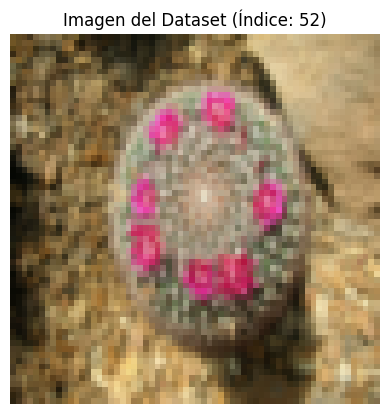

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
Random Forest: No Gato
SVM: No Gato
Gradient Boosting: No Gato
CNN: No Gato
XGBoost: No Gato


In [17]:
imagen = random.randint(0, 209)
predict_image(index=imagen)

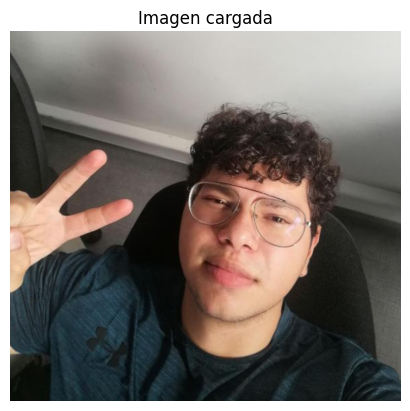

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step

Resultados iniciales de las predicciones:
Random Forest: No Gato
SVM: No Gato
Gradient Boosting: No Gato
CNN: No Gato
XGBoost: No Gato
Random Forest: Predicción correcta. Actualizando para reforzar el modelo...
SVM: Predicción correcta. Actualizando para reforzar el modelo...
Gradient Boosting: Predicción correcta. Actualizando para reforzar el modelo...
CNN: Predicción correcta. Actualizando para reforzar el modelo...
XGBoost: Predicción correcta. Actualizando para reforzar el modelo...


/home/daniel/Universidad/octavoSemestre/aprendizaje/env/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:29:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



¡Actualización completada para todos los modelos!


In [20]:
nombreImagen = "daniel"
url_local = "./imagenesPrueba/"+nombreImagen+".png"
interact_predict_image_v2(local_image_path=url_local)

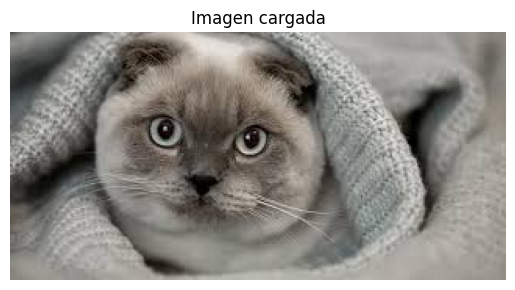

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step

Resultados iniciales de las predicciones:
Random Forest: Gato
SVM: Gato
Gradient Boosting: Gato
CNN: Gato
XGBoost: Gato
Random Forest: Predicción correcta. Actualizando para reforzar el modelo...
SVM: Predicción correcta. Actualizando para reforzar el modelo...
Gradient Boosting: Predicción correcta. Actualizando para reforzar el modelo...
CNN: Predicción correcta. Actualizando para reforzar el modelo...
XGBoost: Predicción correcta. Actualizando para reforzar el modelo...


In [ ]:
# Click derecho --> Copy image adress

url_google = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTQJXi1jgfRWKpQKFVs7HrXsEA-JZH4p5c1KA&s"

interact_predict_image_v2(url_image_data=url_google)